In [1]:
import numpy as np
import os
import re
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import random
from scipy.spatial import KDTree

import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import SplineConv
from torch_geometric.typing import WITH_TORCH_SPLINE_CONV
from torch_geometric.data import Data

/jet/home/ussqww/.conda/envs/pyg/lib/python3.12/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /ocean/projects/eng170006p/ussqww/.conda/envs/pyg/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/jet/home/ussqww/.conda/envs/pyg/lib/python3.12/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /ocean/projects/eng170006p/ussqww/.conda/envs/pyg/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
# check for valid spline_conv
if not WITH_TORCH_SPLINE_CONV:
    quit("This example requires 'torch-spline-conv'")

# Check available GPUs and prepare device list
if torch.cuda.is_available():
    devices = [f'cuda:{i}' for i in range(torch.cuda.device_count())]
else:
    devices = ['cpu']  # fallback to CPU if no GPUs are available
print("Using devices:", devices)

Using devices: ['cuda:0', 'cuda:1']


In [3]:
# Define a function to check if a point is on a line segment between two other points
def is_point_on_segment(p, q, r, tolerance=1e-6):
    """Check if point r lies on the line segment pq."""
    # Calculate vectors
    pq = q - p
    pr = r - p
    
    # Check if r is collinear with p and q
    collinear = np.isclose(np.cross(pq, pr), 0, atol=tolerance)
    if not collinear.all():  # Ensure all collinearity conditions are met
        return False
    
    # Check if r is within the bounds of the segment pq
    within_bounds = np.all(r >= np.minimum(p, q)) and np.all(r <= np.maximum(p, q))
    return within_bounds

# Define a function to hash points into a grid for spatial organization
def grid_hash(points, grid_size=1.0):
    """
    Hashes points into a spatial grid. Each point is assigned to a grid cell, facilitating
    quick spatial queries like proximity checks.

    Args:
        points (array): Array of point coordinates.
        grid_size (float): Dimension size of each grid cell.

    Returns:
        dict: A dictionary where keys are grid cell coordinates and values are lists of point indices in those cells.
    """
    grid = defaultdict(list)
    for idx, point in enumerate(points):
        # Calculate grid cell coordinates based on the point location and grid size.
        grid_key = (int(point[0] // grid_size), int(point[1] // grid_size))
        grid[grid_key].append(idx)
    return grid

def connect_points_in_zone(grid, grid_size=1.0):
    """
    Connects points within the same or adjacent grid cells to form edges, based on their spatial proximity.

    Args:
        grid (dict): A dictionary from grid_hash function mapping grid cells to point indices.
        grid_size (float): The size of each grid cell used in the hashing process.

    Returns:
        set: A set of tuples, each representing an edge between two points.
    """
    edges = set()
    neighbor_offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]
    for key in grid:
        for offset in neighbor_offsets:
            neighbor_key = (key[0] + offset[0], key[1] + offset[1])
            if neighbor_key in grid:
                # Check all points in the current cell against points in the neighboring cell
                for src in grid[key]:
                    for dest in grid[neighbor_key]:
                        if src != dest:
                            edges.add(tuple(sorted([src, dest])))
    return edges

def read_mesh_allCon(filename, grid_size=1.0):
    """
    Reads a VTK file and processes it to extract points, compute spatial connectivity,
    and extract scalar fields. Redefines connectivity based on spatial proximity.

    Args:
        filename (str): Path to the VTK file.
        grid_size (float): Size of the grid cell for spatial hashing.

    Returns:
        tuple: Contains arrays of unique points, deduplicated scalar data, edge list, and edge attributes.
    """
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Parse points
    points_start = lines.index(next(line for line in lines if 'POINTS' in line))
    num_points = int(lines[points_start].split()[1])
    points = np.array([list(map(float, line.strip().split()))[:2] for line in lines[points_start + 1:points_start + 1 + num_points]])

    # Remove duplicates and create spatial hash grid
    unique_points, inverse_indices = np.unique(points, axis=0, return_inverse=True)
    grid = grid_hash(unique_points, grid_size)

    # Compute spatially based edges
    edges = connect_points_in_zone(grid, grid_size)

    # Initialize scalar fields
    scalar_fields = {}
    i = points_start + num_points + 1
    while i < len(lines):
        if 'SCALARS' in lines[i] and 'LOOKUP_TABLE' in lines[i+1]:
            field_name = lines[i].split()[1]
            scalar_values = []
            start = i + 3
            end = min(start + num_points, len(lines))
            for j in range(start, end):
                try:
                    scalar_values.append(float(lines[j].strip()))
                except ValueError:
                    continue
            scalar_fields[field_name] = np.array(scalar_values)
            i = end
        else:
            i += 1

    # Map scalar values to unique points and take maximum values instead of averaging
    deduplicated_data = {name: np.full(len(unique_points), -np.inf) for name in scalar_fields}  # Initialize with negative infinity
    for name, data in scalar_fields.items():
        for idx, value in zip(inverse_indices, data):
            deduplicated_data[name][idx] = max(deduplicated_data[name][idx], value)  # Take max

    # Prepare edge attributes (e.g., distance)
    edge_attributes = [{'node1': a, 'node2': b, 'distance': np.linalg.norm(unique_points[a] - unique_points[b])} for a, b in edges]

    return unique_points, deduplicated_data, edges, edge_attributes

# Define a function to find points near a given line segment for further processing
def get_nearby_points(p, q, grid, points, grid_size=1.0):
    p_grid_key = (int(p[0] // grid_size), int(p[1] // grid_size))
    q_grid_key = (int(q[0] // grid_size), int(q[1] // grid_size))
    min_key = (min(p_grid_key[0], q_grid_key[0]), min(p_grid_key[1], q_grid_key[1]))
    max_key = (max(p_grid_key[0], q_grid_key[0]), max(p_grid_key[1], q_grid_key[1]))
    nearby_points = []
    # Collect all points within the bounding box of the segment pq
    for i in range(min_key[0], max_key[0] + 1):
        for j in range(min_key[1], max_key[1] + 1):
            if (i, j) in grid:
                nearby_points.extend(grid[(i, j)])
    return nearby_points

# Define a function to split edges based on the spatial proximity of nodes
def split_edge_by_nodes(edge, points, grid, grid_size=1.0):
    p, q = edge
    split_points = [p]
    nearby_points = get_nearby_points(points[p], points[q], grid, points, grid_size)
    for r in nearby_points:
        if is_point_on_segment(points[p], points[q], points[r]):
            split_points.append(r)
    split_points.append(q)
    split_points = sorted(set(split_points), key=lambda idx: np.linalg.norm(points[split_points[0]] - points[idx]))
    return [(split_points[i], split_points[i + 1]) for i in range(len(split_points) - 1)]

def read_mesh_cellCon(filename, grid_size=1.0, verbose=1):
    """Reads and processes mesh data from a VTK file, ignoring z-coordinates and checking for NaN or INF values."""
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Find the start and end of the points section
    points_start = lines.index(next(line for line in lines if 'POINTS' in line))
    num_points = int(lines[points_start].split()[1])
    points_end = points_start + 1 + num_points

    # Extract points, ignoring z coordinates if present
    raw_points = [list(map(float, line.strip().split()))[:2] for line in lines[points_start + 1:points_end]]
    raw_points = np.array(raw_points)

    # Check for NaN or INF values in points
    if np.isnan(raw_points).any() or np.isinf(raw_points).any():
        print("Warning: NaN or INF detected in point coordinates.")
        # Optionally handle or filter these values
        raw_points = np.nan_to_num(raw_points, nan=np.finfo(float).min, posinf=np.finfo(float).max, neginf=np.finfo(float).min)

    unique_points, indices = np.unique(raw_points, axis=0, return_inverse=True)

    # Parse scalar fields and handle duplicates by taking the maximum value
    scalar_fields = {}
    i = points_end
    while i < len(lines):
        if 'SCALARS' in lines[i]:
            field_name = lines[i].split()[1]
            lookup_table_start = i + 2  # Points to the start of scalar values
            values = [float(line.strip()) for line in lines[lookup_table_start:lookup_table_start + num_points]]
            if any(np.isnan(values)) or any(np.isinf(values)):
                print(f"Warning: NaN or INF detected in scalar values for field '{field_name}'.")
                values = np.nan_to_num(values, nan=np.finfo(float).min, posinf=np.finfo(float).max, neginf=np.finfo(float).min)
            scalar_fields[field_name] = np.array(values)
            i = lookup_table_start + num_points
        else:
            i += 1

    # Deduplicate scalar fields by taking the maximum value
    deduplicated_data = {name: np.full(len(unique_points), -np.inf, dtype=float) for name in scalar_fields}
    for name, data in scalar_fields.items():
        for i, idx in enumerate(indices):
            deduplicated_data[name][idx] = max(deduplicated_data[name][idx], data[i])

    # Extract elements and compute edge attributes
    cells_start = lines.index(next(line for line in lines if 'CELLS' in line))
    num_cells = int(lines[cells_start].split()[1])
    cells_end = cells_start + 1 + num_cells
    elements = [list(map(int, line.strip().split()))[1:] for line in lines[cells_start + 1:cells_end]]
    elements = [indices[element] for element in elements]

    # Assuming edge_attributes need to be generated or are part of the dataset
    edge_attributes = {}  # This would need actual implementation

    if verbose:
        print("Processed scalar fields:", list(scalar_fields.keys()))
        print("Number of unique points:", len(unique_points))
        print("Sample deduplicated scalar data:", {k: v[:5] for k, v in deduplicated_data.items()})

    return unique_points, deduplicated_data, elements, pd.DataFrame(edge_attributes)

In [4]:
def sort_key_func(filename):
    """
    Extracts numbers from a filename and converts them to an integer for sorting.
    """
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else float('inf')

def read_all_vtk_files_sorted(folder_path, grid_size=1.0):
    """
    Reads all VTK files in the specified folder that have a numeric identifier
    as a multiple of 1000, using the read_mesh function, sorted by numeric order in filenames.

    Args:
        folder_path (str): Path to the folder containing VTK files.
        grid_size (float): The grid size for spatial hashing in the read_mesh function.

    Returns:
        list: A list of tuples where each tuple contains the output of the read_mesh function
              (unique_points, deduplicated_data, elements, edge_attributes) for each file.
    """
    vtk_files = [file for file in os.listdir(folder_path) 
                 if file.startswith("physics_allparticle") and file.endswith(".vtk")]

    vtk_files_sorted = sorted(vtk_files, key=sort_key_func)

    vtk_data_list = []
    for i, filename in enumerate(vtk_files_sorted):
        file_number = int(re.findall(r'\d+', filename)[0])
        if file_number >= 15000 and file_number % 2000 == 0 and file_number <= 17000 :
#         if file_number % 1000 == 0 and file_number <= 15000 :
            filepath = os.path.join(folder_path, filename)
            progress_percent = (i + 1) / len(vtk_files_sorted) * 100
            print(f"Reading {filename}... ({progress_percent:.2f}%)")
            # points, point_data, elements, edge_attributes = read_mesh_cellCon(filepath, 1)
            points, point_data, elements, edge_attributes = read_mesh_allCon(filepath, 2)
            vtk_data_list.append((points, point_data, elements, edge_attributes))

    return vtk_data_list

folder_path = "/ocean/projects/eng170006p/ussqww/TTNG_05052024/io2D_3c02/outputs"
# folder_path = "./dataset/NDDs/io2D_1c01/outputs"  # Replace with your folder path containing VTK files
vtk_data_list = read_all_vtk_files_sorted(folder_path)


Reading physics_allparticle_000000.vtk... (0.07%)
Reading physics_allparticle_002000.vtk... (1.39%)
Reading physics_allparticle_004000.vtk... (2.71%)
Reading physics_allparticle_006000.vtk... (4.03%)
Reading physics_allparticle_008000.vtk... (5.35%)
Reading physics_allparticle_010000.vtk... (6.68%)
Reading physics_allparticle_012000.vtk... (8.00%)
Reading physics_allparticle_014000.vtk... (9.32%)


In [5]:
def calculate_pseudo_coordinates(points, edge_index):
    """Calculate pseudo-coordinates for each edge based on node coordinates."""
    pseudo_coords = []
    for src, dest in edge_index.t().tolist():
        delta_x = points[dest, 0] - points[src, 0]
        delta_y = points[dest, 1] - points[src, 1]
        pseudo_coords.append([delta_x, delta_y])

    pseudo_coords = torch.tensor(pseudo_coords, dtype=torch.float)
    return pseudo_coords

def interpolate_features(current_points, current_point_data, next_points, k=3):
    """
    Interpolate feature data from current points to next points using k-nearest neighbors.
    Sets any resulting NaN or INF values to 0.

    Args:
        current_points (array): Coordinates of current points where data is known.
        current_point_data (dict): Dictionary mapping feature names to arrays of values.
        next_points (array): Coordinates of next points where data needs to be interpolated.
        k (int): Number of nearest neighbors to consider for interpolation.

    Returns:
        dict: A dictionary with interpolated features for each point in next_points.
    """
    tree = KDTree(current_points)
    interpolated_data = {key: np.zeros(len(next_points)) for key in current_point_data.keys()}
    for i, point in enumerate(next_points):
        dists, indices = tree.query(point, k=k)
        if np.isscalar(indices):
            indices = np.array([indices])
            dists = np.array([dists])
        
        weights = 1 / np.maximum(dists, 1e-6)
        weight_sum = np.sum(weights)
        if weight_sum == 0:
            weights = np.ones_like(weights) / len(weights)

        for key in current_point_data.keys():
            feature_values = current_point_data[key][indices]
            interpolated_value = np.dot(weights, feature_values) / weight_sum
            interpolated_data[key][i] = interpolated_value if np.isfinite(interpolated_value) else 0

    return interpolated_data

def create_graph_data(points, point_data, edge_attributes, y_values):
    """
    Create graph data from provided points, elements, point data, edge attributes, and target labels.

    Args:
        points (array): Coordinates of points.
        point_data (dict): Features for each point, expected to be a dict of arrays.
        edge_attributes (list or DataFrame): Attributes for edges.
        y_values (array): Target labels for each point.
    """
    # Convert points to tensor and ensure type is float
    points_tensor = torch.tensor(points, dtype=torch.float)

    # Prepare features tensor by concatenating feature arrays stored in point_data dictionary
    feature_tensors = [torch.tensor(point_data[key], dtype=torch.float).unsqueeze(1) for key in point_data.keys()]
    point_features = torch.cat([points_tensor] + feature_tensors, dim=1)

    # Prepare targets using and next_phi
    y = torch.tensor(y_values, dtype=torch.float)  # Assuming y_values are directly passable to tensor creation

    # Convert edge attributes to tensor
    if isinstance(edge_attributes, list):
        edge_attributes = pd.DataFrame(edge_attributes)
    edge_index = torch.tensor(edge_attributes[['node1', 'node2']].to_numpy().T, dtype=torch.long)

    # Calculate pseudo-coordinates for edge attributes if needed
    pseudo_coords = calculate_pseudo_coordinates(points_tensor, edge_index)
    
    # Construct graph data object
    data = Data(x=point_features, edge_index=edge_index, edge_attr=pseudo_coords, y=y)
    return data

def create_graphs_from_datasets(vtk_data_list):
    graph_data_list = []
    total_datasets = len(vtk_data_list) - 1

    for i in range(total_datasets):
        current_points, current_point_data, _, _ = vtk_data_list[i]
        next_points, next_point_data, _, next_edge_attributes = vtk_data_list[i + 1]

        # Handling both numpy arrays and PyTorch tensors for NaN/Inf checks
        if any(np.isnan(value).any() or np.isinf(value).any() if isinstance(value, np.ndarray) 
               else torch.isnan(value).any() or torch.isinf(value).any() for value in current_point_data.values()):
            print(f"Input data has NaN or Inf in node features at dataset {i}")

        interpolated_point_data = interpolate_features(current_points, current_point_data, next_points, 4)
        if 'theta' in next_point_data:
            interpolated_point_data['theta'] = next_point_data['theta']

        # Again check for NaN or Inf using appropriate functions based on data type
        if any(np.isnan(value).any() or np.isinf(value).any() if isinstance(value, np.ndarray) 
               else torch.isnan(value).any() or torch.isinf(value).any() for value in interpolated_point_data.values()):
            print(f"Interpolated data has NaN or Inf in node features at dataset {i}")
            # Set NaN or INF to 0
            for key, value in interpolated_point_data.items():
                if isinstance(value, np.ndarray):
                    mask = np.isnan(value) | np.isinf(value)
                    interpolated_point_data[key][mask] = 0
                else:
                    mask = torch.isnan(value) | torch.isinf(value)
                    interpolated_point_data[key][mask] = 0

        # y_values = next_point_data['phi']
        
        # Assuming interpolated_point_data and next_point_data are defined and contain 'phi'
        y_values = np.round(interpolated_point_data['phi']) - np.round(next_point_data['phi'])
        # Keeping only positive values
        y_values = np.maximum(y_values, 0)
        # Rounding to 1 decimal place
        y_values = np.round(y_values, 1)

        data = create_graph_data(next_points, interpolated_point_data, next_edge_attributes, y_values)

        if torch.isnan(data.x).any() or torch.isinf(data.x).any():
            print(f"Data object {i} has NaN or Inf in node features 'x'.")

        # Check for NaN or Inf in edge attributes (edge_attr)
        if torch.isnan(data.edge_attr).any() or torch.isinf(data.edge_attr).any():
            print(f"Data object {i} has NaN or Inf in edge attributes 'edge_attr'.")

        # Check for NaN or Inf in labels (y)
        if torch.isnan(data.y).any() or torch.isinf(data.y).any():
            print(f"Data object {i} has NaN or Inf in labels 'y'.")

        graph_data_list.append(data)
        progress_percent = ((i + 1) / total_datasets) * 100
        print(f"Processing dataset {i + 1}/{total_datasets} ({progress_percent:.2f}%) completed")

    return graph_data_list

graph_data_list = create_graphs_from_datasets(vtk_data_list)

Processing dataset 1/7 (14.29%) completed
Processing dataset 2/7 (28.57%) completed
Processing dataset 3/7 (42.86%) completed
Processing dataset 4/7 (57.14%) completed
Processing dataset 5/7 (71.43%) completed
Processing dataset 6/7 (85.71%) completed
Processing dataset 7/7 (100.00%) completed


In [6]:

def plot_graph_components_with_highlights(points, features, edges, edge_attr, y):
    """
    Plots nodes and multiple scalar values in subplots, highlighting in blue the vectors (edges) originating from a randomly selected node,
    based on edge_index, using edge_attr to determine direction and magnitude, and also plots the y-values for each node.

    Args:
        points (numpy.ndarray): Nx2 array of point coordinates.
        features (numpy.ndarray): Array of multiple scalar values associated with each point, dimension NxM.
        edges (numpy.ndarray): Nx2 array of index pairs representing edges.
        edge_attr (torch.Tensor): Tensor containing lengths or vector components for each edge.
        y (numpy.ndarray): Array of scalar values associated with each point, typically used as target labels or another feature.
    """
    random_node = random.randint(0, len(points) - 1)
    num_features = features.shape[1]

    # Layout setup
    num_columns = 3
    num_rows = ((num_features + 2) + num_columns - 1) // num_columns
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(12, 4 * num_rows))
    axs = axs.ravel()

    # Plot node features
    for i in range(num_features):
        scatter = axs[i].scatter(points[:, 0], points[:, 1], c=features[:, i], cmap='viridis', s=20, alpha=0.6, zorder=1)
        axs[i].set_title(f'Feature {i+1}')
        fig.colorbar(scatter, ax=axs[i])

    # Plot y values
    scatter_y = axs[num_features].scatter(points[:, 0], points[:, 1], c=y, cmap='viridis', s=20, alpha=0.6, zorder=1)
    axs[num_features].set_title('Node Distribution with Y Values')
    fig.colorbar(scatter_y, ax=axs[num_features])

    # Prepare to plot edges
    edge_ax = axs[num_features + 1]
    edge_ax.scatter(points[:, 0], points[:, 1], c='lightgray', s=10, alpha=0.5, zorder=1)

    # Plot all edges with lower zorder
    for index, edge in enumerate(edges):
        point_a = points[edge[0]]
        point_b = points[edge[1]]
        dx = edge_attr[index][0]
        dy = edge_attr[index][1]
        edge_ax.plot([point_a[0], point_a[0]+dx], [point_a[1], point_a[1]+dy], color='gray', alpha=0.3, zorder=2, linewidth=1)

    # Plot connected edges last with higher zorder
    for index, edge in enumerate(edges):
        if random_node in edge:
            point_a = points[edge[0]]
            point_b = points[edge[1]]
            dx = edge_attr[index][0]
            dy = edge_attr[index][1]
            edge_ax.plot([point_a[0], point_a[0]+dx], [point_a[1], point_a[1]+dy], color='blue', zorder=3, linewidth=2)

    edge_ax.set_title(f'Edges Highlighting Node {random_node}')
    edge_ax.scatter(points[random_node, 0], points[random_node, 1], color='red', s=30, label='Random Node', zorder=4)
    # edge_ax.legend()

    # Hide any unused axes
    total_plots = num_features + 2
    for i in range(total_plots, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

random_index = random.randint(0, len(graph_data_list) - 1)
graph_data = graph_data_list[random_index]
points = graph_data.x.numpy()[:, :2]
features = graph_data.x.numpy()[:, 2:]  # All features from index 2 to end
edges = graph_data.edge_index.numpy().T
edge_attr = graph_data.edge_attr.numpy()  # Assuming edge_attr contains vector components for each edge
y = graph_data.y.numpy()  # Assuming y contains target values or another feature for each node

# plot_graph_components_with_highlights(points, features, edges, edge_attr, y)

In [7]:
def combine_graph_data(graph_data_list):
    """
    Combines multiple graph data objects into a single graph data object.

    Args:
        graph_data_list (list of Data): List of individual graph data objects to be combined.

    Returns:
        Data: A single combined graph data object containing all node features, edges, edge attributes, and target labels.
    """
    # Initialize lists to hold combined data components
    combined_x = []
    combined_edge_index = []
    combined_edge_attr = []
    combined_y = []
    
    node_offset = 0  # Initial offset for node indices

    # Loop through each individual graph data object
    for data in graph_data_list:
        num_nodes = data.x.size(0)  # Number of nodes in the current graph
        
        # Append node features from the current graph
        combined_x.append(data.x)
        
        # Adjust edge indices by the current node offset and append
        adjusted_edge_index = data.edge_index + node_offset
        combined_edge_index.append(adjusted_edge_index)
        
        # Append edge attributes from the current graph
        combined_edge_attr.append(data.edge_attr)
        
        # Append target labels from the current graph
        combined_y.append(data.y)
        
        # Update the node offset for the next graph
        node_offset += num_nodes
    
    # Concatenate lists into tensors to create a single combined graph
    combined_x = torch.cat(combined_x, dim=0)
    combined_edge_index = torch.cat(combined_edge_index, dim=1)
    combined_edge_attr = torch.cat(combined_edge_attr, dim=0)
    combined_y = torch.cat(combined_y, dim=0)
    
    # Create and return the combined Data object
    combined_data = Data(x=combined_x, edge_index=combined_edge_index, edge_attr=combined_edge_attr, y=combined_y)
    return combined_data

data = combine_graph_data(graph_data_list)
# data.x = data.x[:,:3]
# Print details about the combined graph data
print("Combined Graph Data:")
print(data)

Combined Graph Data:
Data(x=[104027, 7], edge_index=[2, 867492], edge_attr=[867492, 2], y=[104027])


In [8]:
if torch.isnan(data.x).any() or torch.isnan(data.y).any():
    print("NaNs found in the dataset")
if torch.isinf(data.x).any() or torch.isinf(data.y).any():
    print("Infs found in the dataset")

In [9]:
def remove_nodes(data, threshold=1e-1):
    """
    Removes nodes based on the condition that the third channel of x for the node and all its connected nodes 
    is close to 0 or close to 1 within a threshold.

    Args:
        data (Data): PyTorch Geometric Data object with attributes x, edge_index, y, and optionally edge_attr.
        threshold (float): Threshold value to determine closeness to zero or one.

    Returns:
        Data: A new PyTorch Geometric Data object with specified nodes removed.
    """
    num_nodes = data.x.size(0)
    # Create an adjacency list to find connected nodes easily
    adjacency_list = [[] for _ in range(num_nodes)]
    for source, target in data.edge_index.t().tolist():
        adjacency_list[source].append(target)
        adjacency_list[target].append(source)  # Assuming undirected graph

    # Check each node and its neighbors
    keep_nodes = torch.ones(num_nodes, dtype=torch.bool)
    phi_values = data.x[:, 2]  # Assume the 'phi' feature is the third column in x
    for idx in range(num_nodes):
        phi_node = phi_values[idx]
        neighbors_phi = phi_values[adjacency_list[idx]]
        # Check if node and all connected nodes are close to 0 or 1
        if not ((torch.abs(phi_node) <= threshold).item() or (torch.abs(phi_node - 1) <= threshold).item()):
            continue  # If central node phi is not close to 0 or 1, keep it
        if torch.all(torch.abs(neighbors_phi) <= threshold) or torch.all(torch.abs(neighbors_phi - 1) <= threshold):
            keep_nodes[idx] = False  # If all neighbors are also close to 0 or 1, mark for removal

    # Filter nodes, edges, and edge attributes
    new_x = data.x[keep_nodes]
    new_y = data.y[keep_nodes]
    kept_node_indices = torch.where(keep_nodes)[0]
    new_indices = torch.full((num_nodes,), -1, dtype=torch.long)
    new_indices[kept_node_indices] = torch.arange(kept_node_indices.size(0))

    # Filter edges to include only those connecting kept nodes
    edge_mask = (new_indices[data.edge_index[0]] != -1) & (new_indices[data.edge_index[1]] != -1)
    new_edge_index = new_indices[data.edge_index[:, edge_mask]]

    new_edge_attr = data.edge_attr[edge_mask] if data.edge_attr is not None else None

    # Create a new data object with the filtered data
    new_data = Data(x=new_x, edge_index=new_edge_index, y=new_y, edge_attr=new_edge_attr)
    return new_data

# Example usage:
# Assuming 'data' is your original PyTorch Geometric data object
print('Before removing nodes based on phi values')
print(data)
data = remove_nodes(data, threshold=0.01)
print('After removing nodes based on phi values')
print(data)

Before removing nodes based on phi values
Data(x=[104027, 7], edge_index=[2, 867492], edge_attr=[867492, 2], y=[104027])
After removing nodes based on phi values
Data(x=[30958, 7], edge_index=[2, 460578], edge_attr=[460578, 2], y=[30958])


In [10]:
import torch

def remove_nans_and_infs(data):
    # Verify and convert data types for NaN and Inf support if necessary
    data.x = data.x.float() if not data.x.is_floating_point() else data.x
    data.y = data.y.float() if not data.y.is_floating_point() else data.y

    # Check for NaNs and Infs in node features
    nan_inf_nodes_x = torch.isnan(data.x).any(dim=1) | torch.isinf(data.x).any(dim=1)
    print(f"NaNs or Infs in node features: {nan_inf_nodes_x.sum().item()} found.")

    # Check for NaNs and Infs in labels, supports multidimensional labels
    if data.y.dim() > 1:
        nan_inf_nodes_y = torch.isnan(data.y).any(dim=1) | torch.isinf(data.y).any(dim=1)
    else:
        nan_inf_nodes_y = torch.isnan(data.y) | torch.isinf(data.y)
    print(f"NaNs or Infs in labels: {nan_inf_nodes_y.sum().item()} found.")

    # Combine conditions to identify all nodes with any NaN or Inf
    nan_inf_nodes = nan_inf_nodes_x | nan_inf_nodes_y

    if nan_inf_nodes.any():
        print("NaNs or Infs found in the dataset. Removing affected nodes.")
    else:
        print("No NaNs or Infs detected in the nodes.")

    # Filter out nodes with NaNs or Infs
    valid_nodes_indices = (~nan_inf_nodes).nonzero(as_tuple=True)[0]
    data.x = data.x[valid_nodes_indices]
    data.y = data.y[valid_nodes_indices]

    # Update edge_index if present, removing edges connected to NaN or Inf nodes
    if hasattr(data, 'edge_index'):
        edge_index = data.edge_index
        # Filter edges to remove any referencing removed nodes
        mask = (~nan_inf_nodes[edge_index[0]]) & (~nan_inf_nodes[edge_index[1]])
        filtered_edge_index = edge_index[:, mask]

        # Update edge indices to account for removed nodes
        new_index = torch.full((len(nan_inf_nodes),), -1, dtype=torch.long)
        new_index[valid_nodes_indices] = torch.arange(len(valid_nodes_indices), device=edge_index.device)
        data.edge_index = new_index[filtered_edge_index]

    return data

# Example usage
print('Before removing NaN and Inf nodes')
print(data)
data = remove_nans_and_infs(data)
print('After removing NaN and Inf nodes')
print(data)

Before removing NaN and Inf nodes
Data(x=[30958, 7], edge_index=[2, 460578], edge_attr=[460578, 2], y=[30958])
NaNs or Infs in node features: 0 found.
NaNs or Infs in labels: 0 found.
No NaNs or Infs detected in the nodes.
After removing NaN and Inf nodes
Data(x=[30958, 7], edge_index=[2, 460578], edge_attr=[460578, 2], y=[30958])


In [11]:
# Ensure y (labels) is of shape [num_nodes]
data.y = data.y.view(-1)  # Ensure y is 1D [num_nodes]

# Number of nodes in the graph
num_nodes = data.x.size(0)  # Infer the number of nodes from x
num_train = int(num_nodes * 0.8)  # 80% of nodes for training
num_test = num_nodes - num_train  # 20% of nodes for testing

# Randomly permute node indices to create random train, validation, and test splits
perm = torch.randperm(num_nodes)

# Initialize masks for train and test sets
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Assign masks based on the random permutation
train_mask[perm[:num_train]] = True
test_mask[perm[num_train:]] = True

# Assign masks to the Data object
data.train_mask = train_mask
data.test_mask = test_mask

# Optional: Create a validation mask from the training set
num_val = int(num_train * 0.1)  # 10% of the training set for validation
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[perm[:num_val]] = True

# Assign validation mask to the Data object
data.val_mask = val_mask

data.num_classes = 2  # Assuming your problem is binary classification

data.y = data.y.float()
# Print the final structured data object
print(data)

Data(x=[30958, 7], edge_index=[2, 460578], edge_attr=[460578, 2], y=[30958], train_mask=[30958], test_mask=[30958], val_mask=[30958], num_classes=2)


In [12]:
def min_max_normalize_features(x):
    """
    Normalizes each feature in the x tensor to be between 0 and 1.

    Args:
        x (torch.Tensor): A tensor of shape [N, F] where N is the number of nodes and F is the number of features.

    Returns:
        torch.Tensor: The normalized feature tensor.
    """
    min_vals = torch.min(x, dim=0)[0]
    max_vals = torch.max(x, dim=0)[0]
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1  # Prevent division by zero to handle features that are constant
    print(min_vals)
    print(max_vals)
    print(range_vals)
    normalized_x = (x - min_vals) / range_vals

    return normalized_x

def add_gradient_features(data, edge_index):
    """
    Adds gradient features to the data.x tensor based on the differences in feature values along edges.
    The gradient is calculated using the pseudo-coordinates stored in edge_attr and added to the node features.

    Args:
        data (torch_geometric.data.Data): The data object containing node features and edge attributes.
        edge_index (torch.Tensor): Tensor containing the indices of source and destination nodes for each edge.

    Returns:
        data (torch_geometric.data.Data): The modified data object with additional gradient features.
    """
    num_features = data.x.shape[1] - 2  # Exclude the coordinate columns
    epsilon = 1e-6  # Small number to prevent division by zero

    for i in range(num_features):
        feature_values = data.x[:, i+2]
        gradients = torch.zeros_like(data.x[:, :2])  # Only two columns for gradient (dx, dy)

        for j, (src, dest) in enumerate(edge_index.t()):
            pseudo_coords = data.edge_attr[j]
            dx, dy = pseudo_coords[0], pseudo_coords[1]  # Assuming pseudo_coords are stored as [dx, dy]

            # Calculate gradient components separately and safely
            gradient_x = (feature_values[dest] - feature_values[src]) / (dx + epsilon)
            gradient_y = (feature_values[dest] - feature_values[src]) / (dy + epsilon)
            
            gradients[src, 0] += gradient_x
            gradients[src, 1] += gradient_y
            gradients[dest, 0] -= gradient_x
            gradients[dest, 1] -= gradient_y  # Symmetric impact

        # Concatenate gradient features to original features
        data.x = torch.cat([data.x, gradients], dim=1)

        print(f"Processed feature {i+1}/{num_features} ({(i+1) / num_features * 100:.1f}%)")

    return data

def rotate_points(data, angle_degrees):
    """
    Rotates the point coordinates in the data.x tensor by a specified angle.

    Args:
        data (torch_geometric.data.Data): The data object containing node features.
        angle_degrees (float): The angle in degrees to rotate the point coordinates.

    Returns:
        data (torch_geometric.data.Data): The modified data object with rotated coordinates.
    """
    angle = np.radians(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])

    # Assume the first two columns in x are coordinates
    coords = data.x[:, :2].numpy()
    new_coords = np.dot(coords, rotation_matrix)
    data.x[:, :2] = torch.tensor(new_coords, dtype=torch.float32)

    print(f"Rotated points by {angle_degrees} degrees.")
    return data

def oversample_minority_class(data):
    """
    Duplicates samples of the minority class in the dataset to balance class distribution.

    Args:
        data (torch_geometric.data.Data): The data object containing node labels and optionally masks.

    Returns:
        data (torch_geometric.data.Data): The modified data object with duplicated minority class samples.
    """
    unique, counts = torch.unique(data.y, return_counts=True)
    minority_class = unique[torch.argmin(counts)]

    # Indices of the minority class
    minority_indices = (data.y == minority_class).nonzero(as_tuple=True)[0]
    
    # Duplicate minority class samples
    minority_x = data.x[minority_indices]
    minority_y = data.y[minority_indices]
    
    # Update the data object
    data.x = torch.cat([data.x, minority_x], dim=0)
    data.y = torch.cat([data.y, minority_y], dim=0)

    # Update masks if they exist
    if hasattr(data, 'train_mask'):
        minority_mask = data.train_mask[minority_indices]
        data.train_mask = torch.cat([data.train_mask, minority_mask], dim=0)
    if hasattr(data, 'test_mask'):
        minority_mask = data.test_mask[minority_indices]
        data.test_mask = torch.cat([data.test_mask, minority_mask], dim=0)
    if hasattr(data, 'val_mask'):
        minority_mask = data.val_mask[minority_indices]
        data.val_mask = torch.cat([data.val_mask, minority_mask], dim=0)
    
    print(f"Duplicating node {idx.item()} for minority class ({minority_class}); Progress: {len(data.y) / len(minority_indices) * 100:.1f}%")
    return data

In [13]:
# data.x[:, 2] = np.round(data.x[:, 2], decimals=2)

# data.x = data.x[:, :3]

# data.y = np.round(data.y)

In [14]:
# Normalize features
data.x = min_max_normalize_features(data.x)
data.edge_attr = min_max_normalize_features(data.edge_attr)
data.y = min_max_normalize_features(data.y)

# # Add gradient features
# data = add_gradient_features(data, data.edge_index)
# print('Done adding gradient features')

# # Optionally, rotate points for augmentation
# data = rotate_points(data, 45)  # Rotate by 45 degrees
# print('Done rotating points')

# # Oversample minority class to balance the dataset
# data = oversample_minority_class(data)
# print('Done oversampling minority class')

# Print data to verify changes
print(data)

tensor([ 0.0000e+00,  8.0000e+00, -1.3785e-02, -3.4420e-02, -1.5820e-13,
        -1.3889e-01,  1.5106e-01])
tensor([178.0000, 206.0000,   1.0617,   1.3434,   0.9028,   2.2222,   0.8798])
tensor([178.0000, 198.0000,   1.0755,   1.3778,   0.9028,   2.3611,   0.7287])
tensor([ 0., -3.])
tensor([3., 3.])
tensor([3., 6.])
tensor(0.)
tensor(1.)
tensor(1.)
Data(x=[30958, 7], edge_index=[2, 460578], edge_attr=[460578, 2], y=[30958], train_mask=[30958], test_mask=[30958], val_mask=[30958], num_classes=2)


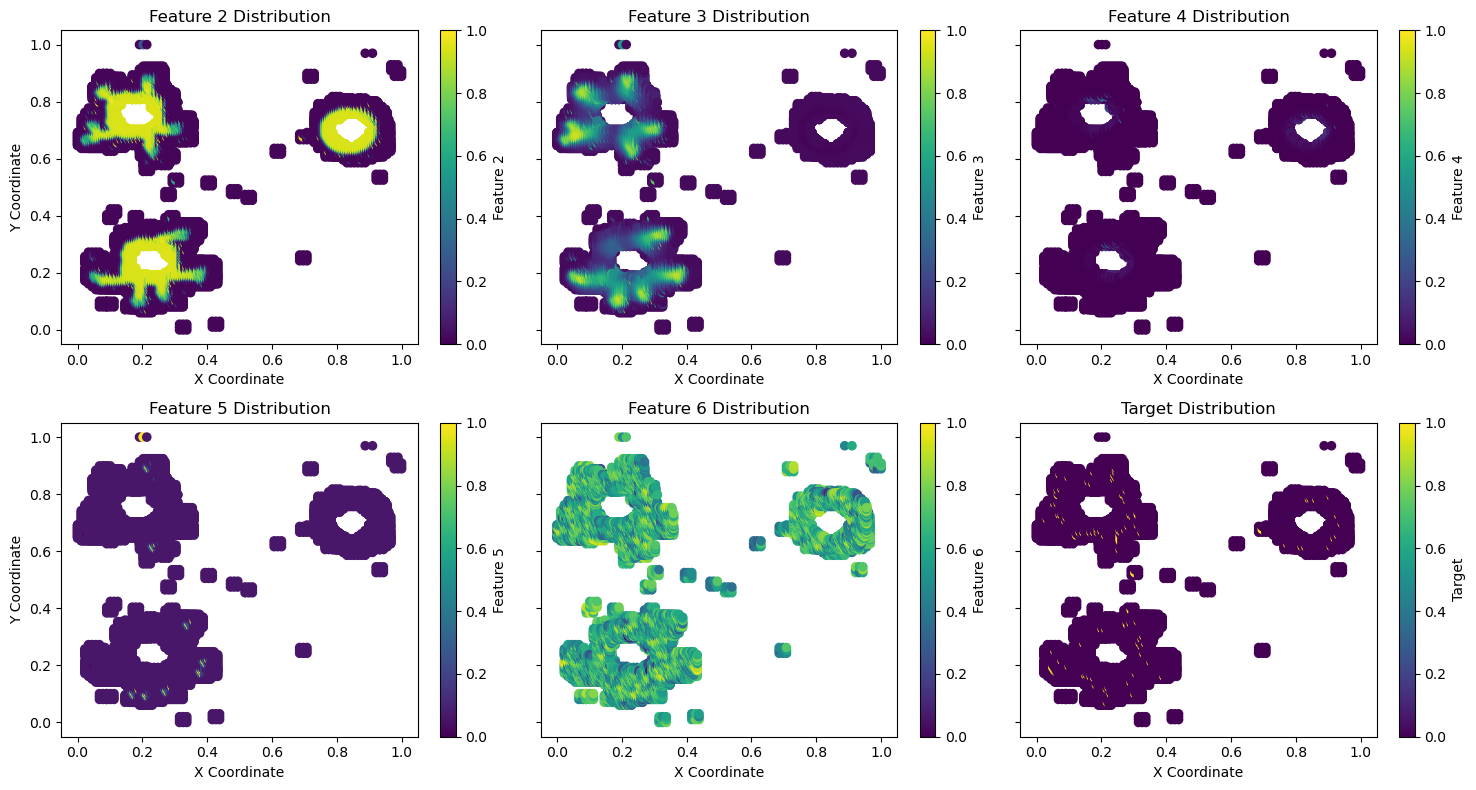

In [15]:
def plot_features_and_target(data):
    """
    Plots each feature and the target variable from the dataset based on the coordinates.

    Args:
        data (torch_geometric.data.Data): The data object containing node features, where
            the first two columns are assumed to be x and y coordinates.

    Displays:
        Scatter plots for each feature and the target variable, colored by their values.
    """
    if data.x is None or data.y is None:
        print("Node features or target values are missing in the dataset.")
        return

    # Coordinates are the first two columns
    coords = data.x[:, :2].numpy()
    num_features = data.x.size(1) - 2  # excluding the coordinate columns

    # Setup plot grid
    num_plots = num_features + 1  # Plus one for the target variable
    cols = 3  # Set number of columns for subplots
    rows = (num_plots + cols - 1) // cols  # Calculate the required number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharey=True, squeeze=False)

    # Plot each feature
    for i in range(num_plots):
        ax = axes[i // cols, i % cols]  # Determine row and column index
        if i < num_features:
            sc = ax.scatter(coords[:, 0], coords[:, 1], c=data.x[:, i+2].numpy(), cmap='viridis', s=35)
            fig.colorbar(sc, ax=ax, label=f'Feature {i+2}')
            ax.set_title(f'Feature {i+2} Distribution')
        else:
            # Plot the target variable
            sc = ax.scatter(coords[:, 0], coords[:, 1], c=data.y.numpy(), cmap='viridis', s=35)
            fig.colorbar(sc, ax=ax, label='Target')
            ax.set_title('Target Distribution')

        ax.set_xlabel('X Coordinate')
        if i % cols == 0:  # Only set y-label on the first column
            ax.set_ylabel('Y Coordinate')

    # Hide empty subplots if any
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j // cols, j % cols])

    plt.tight_layout()
    plt.show()

plot_features_and_target(data)

In [16]:
# Example check for NaNs in your data
if torch.isnan(data.x).any() or torch.isnan(data.y).any():
    print("NaNs found in the dataset")

In [17]:
# !mkdir ./generated_data
# # Assuming 'data' is your PyTorch Geometric Data object
# torch.save(data, './generated_data/NDD.pt')
# # Load a single data object
# data = torch.load('./generated_data/NDD_per1000.pt')

In [18]:
print(data)
print(max(data.x[:,2]))
print(data.x)
print(max(data.y))
print(data.y)

Data(x=[30958, 7], edge_index=[2, 460578], edge_attr=[460578, 2], y=[30958], train_mask=[30958], test_mask=[30958], val_mask=[30958], num_classes=2)
tensor(1.)
tensor([[8.9888e-02, 7.0707e-01, 1.2817e-02,  ..., 1.7522e-13, 5.8824e-02,
         6.6704e-01],
        [8.9888e-02, 7.1212e-01, 1.2817e-02,  ..., 1.7522e-13, 5.8824e-02,
         4.9903e-01],
        [8.9888e-02, 7.1717e-01, 1.2817e-02,  ..., 1.7522e-13, 5.8824e-02,
         4.3689e-01],
        ...,
        [1.0000e+00, 8.8889e-01, 1.2817e-02,  ..., 1.7522e-13, 5.8824e-02,
         4.2660e-01],
        [1.0000e+00, 8.9899e-01, 1.2817e-02,  ..., 2.3267e-08, 5.8824e-02,
         7.1096e-01],
        [1.0000e+00, 9.0909e-01, 1.2817e-02,  ..., 1.7522e-13, 5.8824e-02,
         6.8923e-01]])
tensor(1.)
tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [19]:
def print_random_y_values(data):
    """
    Randomly selects and prints 10 values from the data.y tensor.

    Args:
        data (torch_geometric.data.Data): The data object containing the y attribute
            which is a tensor of shape [N] where N is the number of elements.

    """
    num_samples = 20  # Number of samples to print
    num_elements = data.y.size(0)  # Total number of elements in data.y

    # Ensure we don't sample more elements than available
    if num_elements < num_samples:
        num_samples = num_elements

    # Randomly choose indices without replacement
    indices = torch.randperm(num_elements)[:num_samples]

    # Fetch the selected elements
    selected_values = data.y[indices]

    # Print the selected values
    print("Randomly selected data.y values:")
    for index, value in zip(indices, selected_values):
        print(f'Index {index.item()}: {value.item()}')

print_random_y_values(data)


Randomly selected data.y values:
Index 1029: 0.0
Index 15098: 0.0
Index 25493: 0.0
Index 19357: 0.0
Index 4282: 0.0
Index 25730: 0.0
Index 10172: 0.0
Index 27040: 0.0
Index 3508: 0.0
Index 24473: 0.0
Index 13920: 0.0
Index 15082: 0.0
Index 12254: 0.0
Index 5946: 0.0
Index 17783: 0.0
Index 767: 0.0
Index 16271: 0.0
Index 7428: 0.0
Index 30243: 0.0
Index 14046: 0.0


In [20]:
print(data)

Data(x=[30958, 7], edge_index=[2, 460578], edge_attr=[460578, 2], y=[30958], train_mask=[30958], test_mask=[30958], val_mask=[30958], num_classes=2)


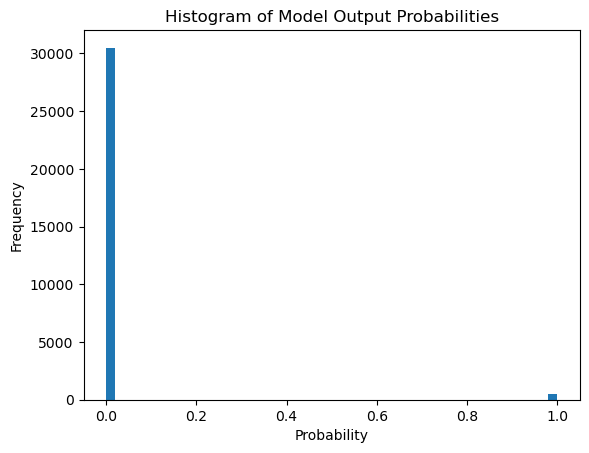

In [21]:
plt.hist(data.y.numpy(), bins=50)
plt.title('Histogram of Model Output Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

In [22]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = SplineConv(dataset.num_features, 32, dim=2, kernel_size=4, is_open_spline=True, degree=3, aggr="max", root_weight=True, bias=True)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.conv2 = SplineConv(32, 64, dim=2, kernel_size=4, is_open_spline=True, degree=3, aggr="max", root_weight=True, bias=True)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.conv3 = SplineConv(64, 128, dim=2, kernel_size=4, is_open_spline=True, degree=3, aggr="max", root_weight=True, bias=True)
        self.bn3 = torch.nn.BatchNorm1d(128)
        self.conv4 = SplineConv(128, 1, dim=2, kernel_size=4, is_open_spline=True, degree=3, aggr="max", root_weight=True, bias=True)
        self.bn4 = torch.nn.BatchNorm1d(64)
        # self.conv5 = SplineConv(64, 1, dim=2, kernel_size=4, is_open_spline=True, degree=2, aggr="add", root_weight=True, bias=True)
        # self.bn5 = torch.nn.BatchNorm1d(1)
        self.fc = torch.nn.Linear(1,1)


    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = F.elu(x)
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = F.elu(x)
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv3(x, edge_index, edge_attr)
        x = self.bn3(x)
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv4(x, edge_index, edge_attr)
        x = F.elu(x)
        # x = self.fc(x)  # Linear layer for adjusting outputs before final activation
        x = torch.sigmoid(x)  # Sigmoid activation to output probabilities
        return x

class SplineCNN_SuperPixelNet(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        # First SplineConv layer
        self.conv1 = SplineConv(dataset.num_features, 32, dim=2, kernel_size=4, is_open_spline=True, degree=2, aggr="add", root_weight=True, bias=True)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.pool1 = torch.nn.MaxPool2d(4)  # Pooling layers might not be directly applicable depending on your graph structure

        # Second SplineConv layer
        self.conv2 = SplineConv(32, 64, dim=2, kernel_size=4, is_open_spline=True, degree=2, aggr="add", root_weight=True, bias=True)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.pool2 = torch.nn.MaxPool2d(4)

        # Global Average Pooling
        self.glob_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))  # Adjusted to graph's pooled feature dimensions

        # Fully connected layers
        self.fc1 = torch.nn.Linear(64, 128)
        self.fc2 = torch.nn.Linear(128, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # First SplineConv layer
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = F.elu(x)
        # Note: MaxPool2d is not directly applicable to graph data without a spatial feature representation

        # Second SplineConv layer
        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = F.elu(x)
        # Note: Again, MaxPool2d is not directly applicable here

        # Adjust pooling here to match graph data requirements
        # x = self.glob_avg_pool(x)  # Needs to be adapted if x is not a batched feature map

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = F.elu(self.fc1(x))
        x = self.fc2(x)

        return x

from torch_geometric.nn import GCNConv

class GCNNet(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 32)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.conv2 = GCNConv(32, 64)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.conv3 = GCNConv(64, 128)
        self.bn3 = torch.nn.BatchNorm1d(128)
        self.conv4 = GCNConv(128, 1)
        # Define more layers as needed, using torch.nn for any necessary components.

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.elu(x)
        
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv4(x, edge_index)
        x = F.elu(x)
        
        x = torch.sigmoid(x)  # Use sigmoid for binary classification problems
        return x

from torch_geometric.nn import GATConv
class GATNet(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = GATConv(dataset.num_features, 32, heads=8, dropout=0.6)
        self.conv2 = GATConv(32 * 8, 64, heads=8, dropout=0.6)  # Adjust according to your model setup
        self.conv3 = GATConv(64 * 8, 128, heads=8, dropout=0.6)
        self.conv4 = GATConv(128 * 8, 1, heads=1, concat=False, dropout=0.6)  # Ensuring single output per node
        self.fc = torch.nn.Linear(1, 1)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv4(x, edge_index)
        # x = self.fc(x) 
        x = torch.sigmoid(x)  # or no activation if purely regression without bounded output
        return x

In [23]:
class HybridGAT_SplineNet(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        # Initialize GATConv with attention mechanism
        self.gat1 = GATConv(dataset.num_features, 32, heads=8, dropout=0.6)
        
        # Initialize SplineConv for capturing complex patterns with spline kernels
        self.spline1 = SplineConv(32 * 8, 64, dim=2, kernel_size=5, aggr='max')
        
        # Another layer of GATConv to focus on attention-based feature refinement
        self.gat2 = GATConv(64, 64, heads=8, dropout=0.6, concat=True)
        
        # Final SplineConv layer for detailed feature extraction before output
        self.spline2 = SplineConv(64 * 8, 1, dim=2, kernel_size=5, aggr='max')
        
        self.dropout_rate = 0.6

    def forward(self, data):
        x, edge_index, pseudo = data.x, data.edge_index, data.edge_attr
        # Ensure pseudo coordinates are provided for SplineConv layers
        
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.gat1(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.spline1(x, edge_index, pseudo)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.spline2(x, edge_index, pseudo)

        x = torch.sigmoid(x)  # Assuming binary classification or sigmoid needed for final output
        return x

In [24]:
# def train():
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask].unsqueeze(1))  # Use MSE loss for continuous output
#     loss.backward()
    
#     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#     optimizer.step()

# @torch.no_grad()
# def test():
#     model.eval()
#     out = model(data)  # Output shape: [num_nodes, 1]
#     out = out.squeeze()  # Squeeze to match target shape [num_nodes]

#     train_error = F.mse_loss(out[data.train_mask], data.y[data.train_mask]).item()
#     test_error = F.mse_loss(out[data.test_mask], data.y[data.test_mask]).item()
    
#     return train_error, test_error


def train():
    model.train()
    optimizer.zero_grad()

    # Get the model output
    out = model(data)

    # Ensure the output is between 0 and 1 by applying a sigmoid, if not already included in the model
    out_prob = torch.sigmoid(out[data.train_mask])

    # Ensure the target labels are of the correct shape [num_nodes, 1] and type float
    target = data.y[data.train_mask].unsqueeze(1).float()

    # Use binary cross-entropy loss
    loss = F.binary_cross_entropy(out_prob, target)

    # Perform backpropagation and an optimization step
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()


@torch.no_grad()
def test():
    model.eval()

    # Get the model output
    out = model(data)

    # Ensure the output is between 0 and 1 by applying a sigmoid
    out_prob = torch.sigmoid(out)

    # Calculate binary cross-entropy loss for train and test sets
    train_loss = F.binary_cross_entropy(out_prob[data.train_mask], data.y[data.train_mask].unsqueeze(1).float()).item()
    test_loss = F.binary_cross_entropy(out_prob[data.test_mask], data.y[data.test_mask].unsqueeze(1).float()).item()

    return train_loss, test_loss

# from torch_geometric.data import Batch

# def train():
#     model.train()
#     optimizer.zero_grad()

#     # Assuming 'devices' and 'data' are properly defined
#     data_list = [data.to(device) for device in devices]  # List of data objects for each GPU
#     out = model(data_list)  # Model should handle parallel execution and gathering

#     # Ensure outputs are gathered to a single device, typically cuda:0
#     out_prob = torch.sigmoid(out)  # This should be on a single device after gather
#     device = out_prob.device  # Device where the output is located

#     # Gather targets to the same device as out_prob
#     targets = torch.cat([d.y[d.train_mask].unsqueeze(1).float().to(device) for d in data_list])

#     # Compute loss
#     loss = F.binary_cross_entropy(out_prob, targets)
#     loss.backward()
#     optimizer.step()


# @torch.no_grad()
# def test():
#     model.eval()

#     # Get the model output
#     out = model(data)

#     # Apply sigmoid activation
#     out_prob = torch.sigmoid(out)

#     # Calculate binary cross-entropy loss for train and test sets
#     train_loss = F.binary_cross_entropy(out_prob[data.train_mask], data.y[data.train_mask].unsqueeze(1).float()).item()
#     test_loss = F.binary_cross_entropy(out_prob[data.test_mask], data.y[data.test_mask].unsqueeze(1).float()).item()

#     return train_loss, test_loss

In [25]:
from torch_geometric.nn import GCNConv

class ResidualGCNBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, out_channels)
        self.conv2 = GCNConv(out_channels, out_channels)
        if in_channels != out_channels:
            self.projection = torch.nn.Linear(in_channels, out_channels)
        else:
            self.projection = None

    def forward(self, x, edge_index):
        identity = x
        out = F.relu(self.conv1(x, edge_index))
        out = self.conv2(out, edge_index)
        
        if self.projection is not None:
            identity = self.projection(identity)
        
        out += identity  # Residual connection
        out = F.relu(out)
        return out

class ResidualGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.5):
        super().__init__()
        self.initial_conv = GCNConv(in_channels, hidden_channels)
        self.res_blocks = torch.nn.ModuleList([ResidualGCNBlock(hidden_channels, hidden_channels) for _ in range(num_layers - 1)])
        self.final_conv = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.initial_conv(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        for block in self.res_blocks:
            x = block(x, edge_index)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.final_conv(x, edge_index)
        return x

# def train(model, data, optimizer):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)  # Shape should be [number of nodes, 1] for regression
#     out = out[data.train_mask]  # Applying mask
#     targets = data.y[data.train_mask].float()  # Ensure targets are float for MSE loss
#     loss = F.mse_loss(out, targets)  # Use MSE loss for continuous output
#     loss.backward()
#     optimizer.step()
#     return loss.item()

# def accuracy(output, labels, threshold=0.1):
#     """Calculate accuracy within a given threshold."""
#     return (output.sub(labels).abs() < threshold).float().mean().item()

# def evaluate(model, data):
#     model.eval()
#     with torch.no_grad():
#         out = model(data).squeeze()  # Squeeze to remove extra dimension from output

#         train_masked_out = out[data.train_mask]
#         test_masked_out = out[data.test_mask]
#         train_labels = data.y[data.train_mask].float()
#         test_labels = data.y[data.test_mask].float()

#         train_acc = accuracy(train_masked_out, train_labels)
#         test_acc = accuracy(test_masked_out, test_labels)

#         return train_acc, test_acc

# # Setup for model training/testing
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ResidualGCN(data.num_node_features, 64, 1, num_layers=3).to(device)  # Assuming the output is 1 for regression
# data = data.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# # Lists to store training and test accuracy for each epoch
# train_acc_list = []
# test_acc_list = []

# # Example training loop
# for epoch in range(1, 101):
#     train_loss = train(model, data, optimizer)
#     train_acc, test_acc = evaluate(model, data)
#     train_acc_list.append(train_acc)
#     test_acc_list.append(test_acc)
#     print(f'Epoch {epoch}: Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')



In [26]:
print(data)

Data(x=[30958, 7], edge_index=[2, 460578], edge_attr=[460578, 2], y=[30958], train_mask=[30958], test_mask=[30958], val_mask=[30958], num_classes=2)


In [27]:
def check_tensor(tensor, name="Tensor"):
    if torch.isnan(tensor).any() or torch.isinf(tensor).any():
        print(f"{name} contains NaN or Inf.")

# Example usage in your training loop
check_tensor(data.x, "Input Features")

In [28]:
# import os
# import torch
# import torch.distributed as dist
# import torch.multiprocessing as mp
# import torch.nn as nn
# import torch.optim as optim
# from torch.nn.parallel import DistributedDataParallel as DDP

# def setup(rank, world_size):
#     os.environ['MASTER_ADDR'] = 'localhost'
#     os.environ['MASTER_PORT'] = '29500'
#     dist.init_process_group("nccl", rank=rank, world_size=world_size)
#     torch.cuda.set_device(rank)

# def cleanup():
#     dist.destroy_process_group()

# def train(rank, world_size, model, data, optimizer):
#     torch.cuda.set_device(rank)
#     model.train()

#     # Assuming data is distributed and gathered correctly
#     data = data.to(rank)
#     optimizer.zero_grad()
#     out = model(data)
#     out_prob = torch.sigmoid(out)
#     targets = data.y[data.train_mask].unsqueeze(1).float()
#     loss = nn.functional.binary_cross_entropy(out_prob, targets)
#     loss.backward()
#     optimizer.step()

# @torch.no_grad()
# def test(rank, model, data):
#     model.eval()
#     data = data.to(rank)
#     out = model(data)
#     out_prob = torch.sigmoid(out)
#     loss = nn.functional.binary_cross_entropy(out_prob, data.y[data.test_mask].unsqueeze(1).float())
#     return loss.item()

# def run(rank, world_size, data):
#     setup(rank, world_size)
#     model = GATNet(data).to(rank)
#     model = DDP(model, device_ids=[rank])
#     optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

#     for epoch in range(1, 201):
#         train(rank, world_size, model, data, optimizer)
#         if rank == 0:  # Only print from rank 0
#             loss = test(rank, model, data)
#             print(f'Epoch {epoch}, Loss: {loss}')

#     cleanup()

# world_size = torch.cuda.device_count()
# mp.spawn(run,
#          args=(world_size, data),
#          nprocs=world_size,
#          join=True)


In [29]:
# check and printout device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

print(data)

# GPU Memory Monitoring Function
def print_gpu_memory(device):
    torch.cuda.synchronize(device)
    allocated = torch.cuda.memory_allocated(device)
    reserved = torch.cuda.memory_reserved(device)
    print(f"Allocated memory: {allocated / (1024**3):.3f} GB")
    print(f"Reserved memory: {reserved / (1024**3):.3f} GB")

# Initialize the Net model
# model = SplineCNN_SuperPixelNet(data)
# model = Net(data)  # Instantiate the model with the data
# model = GCNNet(data)
model = GATNet(data)
# model = HybridGAT_SplineNet(data)

# Initialize weights
def weights_init(m):
    if hasattr(m, 'weight') and hasattr(m.weight, 'data'):
        torch.nn.init.xavier_uniform_(m.weight.data)
    if hasattr(m, 'bias') and m.bias is not None:
        torch.nn.init.constant_(m.bias.data, 0.0)

# Apply weights initialization
model.apply(weights_init)

# Move to the appropriate device
model = model.to(device)
data = data.to(device)

# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

# Lists to store training and test accuracy for each epoch
train_acc_list = []
test_acc_list = []

for epoch in range(1, 201):
    train()
    train_acc, test_acc = test()
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Test: {test_acc:.4f}')

    if epoch % 20 == 0:
        !nvidia-smi
        print_gpu_memory(device)

cuda
Data(x=[30958, 7], edge_index=[2, 460578], edge_attr=[460578, 2], y=[30958], train_mask=[30958], test_mask=[30958], val_mask=[30958], num_classes=2)
Epoch: 001, Train: 0.6933, Test: 0.6933
Epoch: 002, Train: 0.6932, Test: 0.6932
Epoch: 003, Train: 0.6932, Test: 0.6932
Epoch: 004, Train: 0.6932, Test: 0.6932
Epoch: 005, Train: 0.6932, Test: 0.6932
Epoch: 006, Train: 0.6932, Test: 0.6932
Epoch: 007, Train: 0.6932, Test: 0.6932
Epoch: 008, Train: 0.6932, Test: 0.6932
Epoch: 009, Train: 0.6932, Test: 0.6932
Epoch: 010, Train: 0.6932, Test: 0.6932
Epoch: 011, Train: 0.6933, Test: 0.6933
Epoch: 012, Train: 0.6934, Test: 0.6934
Epoch: 013, Train: 0.6935, Test: 0.6935
Epoch: 014, Train: 0.6937, Test: 0.6937
Epoch: 015, Train: 0.6940, Test: 0.6940
Epoch: 016, Train: 0.6941, Test: 0.6941
Epoch: 017, Train: 0.6940, Test: 0.6940
Epoch: 018, Train: 0.6939, Test: 0.6939
Epoch: 019, Train: 0.6937, Test: 0.6937
Epoch: 020, Train: 0.6936, Test: 0.6936
Tue Aug 27 15:56:13 2024       
+-------------

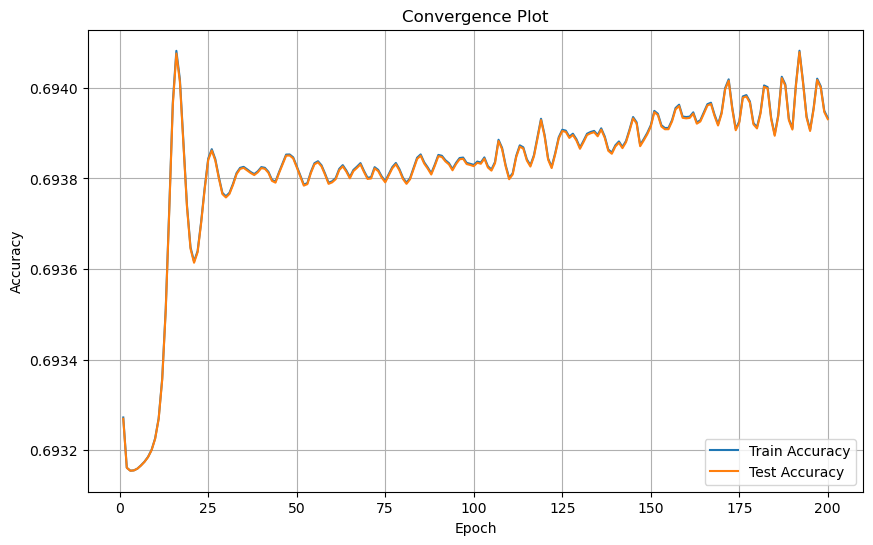

In [30]:
# Plot the convergence of training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, len(test_acc_list) + 1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Convergence Plot')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
@torch.no_grad()
def evaluate_model_regression(data, model):
    model.eval()
    out = model(data)
    
    actual = data.y[data.test_mask]
    print(actual.size())
    
    # # Calculate Mean Squared Error
    # mse = F.mse_loss(out[data.test_mask], actual)
    # print(f'Test MSE: {mse.item():.4f}')

    # Ensure output is within the [0, 1] range using sigmoid (if not already applied in the model)
    out_prob = torch.sigmoid(out[data.test_mask]).squeeze()  # Apply sigmoid to ensure the outputs are probabilities.
    # Calculate Binary Cross-Entropy
    bce = F.binary_cross_entropy(out_prob, actual)
    print(f'Test BCE: {bce.item():.4f}')

    # Print sample predictions for checking
    print("\nSample Predictions:")
    num_samples = min(10, out[data.test_mask].size(0))
    for i in range(num_samples):
        print(f'Predicted: {out[data.test_mask][i].item():.4f}, Actual: {actual[i].item():.4f}')

evaluate_model_regression(data, model)

torch.Size([6192])
Test BCE: 0.6939

Sample Predictions:
Predicted: 0.0019, Actual: 0.0000
Predicted: 0.0019, Actual: 0.0000
Predicted: 0.0021, Actual: 0.0000
Predicted: 0.0019, Actual: 0.0000
Predicted: 0.0020, Actual: 0.0000
Predicted: 0.0021, Actual: 0.0000
Predicted: 0.0021, Actual: 0.0000
Predicted: 0.0020, Actual: 0.0000
Predicted: 0.0020, Actual: 0.0000
Predicted: 0.0021, Actual: 0.0000


torch.Size([6192])
Test BCE: 0.6939
Test Accuracy: 0.0000

Sample Predictions:
Pred label: 0.5002816319465637, Out prob: 0.5003, Actual: 0
Pred label: 0.5002567768096924, Out prob: 0.5003, Actual: 0
Pred label: 0.5005268454551697, Out prob: 0.5005, Actual: 0
Pred label: 0.5002542734146118, Out prob: 0.5003, Actual: 0
Pred label: 0.5002231001853943, Out prob: 0.5002, Actual: 0
Pred label: 0.5004710555076599, Out prob: 0.5005, Actual: 0
Pred label: 0.5005782246589661, Out prob: 0.5006, Actual: 0
Pred label: 0.5004651546478271, Out prob: 0.5005, Actual: 0
Pred label: 0.5006355047225952, Out prob: 0.5006, Actual: 0
Pred label: 0.5003178715705872, Out prob: 0.5003, Actual: 0
Pred label: 0.5005188584327698, Out prob: 0.5005, Actual: 0
Pred label: 0.5003594756126404, Out prob: 0.5004, Actual: 0
Pred label: 0.5004715919494629, Out prob: 0.5005, Actual: 0
Pred label: 0.5002013444900513, Out prob: 0.5002, Actual: 0
Pred label: 0.5003669857978821, Out prob: 0.5004, Actual: 0
Pred label: 0.5002033

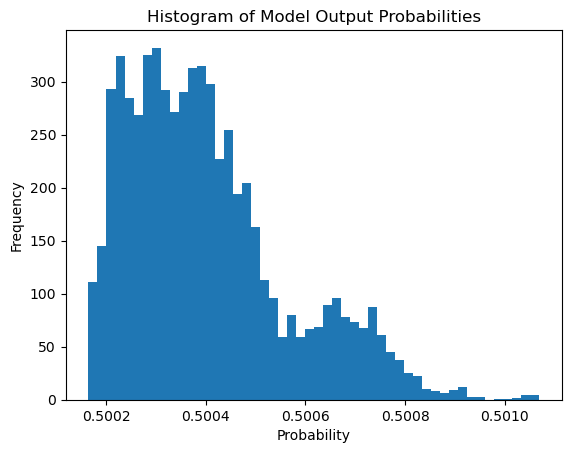

In [32]:
@torch.no_grad()
def evaluate_model_regression(data, model):
    model.eval()
    out = model(data)
    
    actual = data.y[data.test_mask]
    print(actual.size())
    
    # Ensure output is within the [0, 1] range using sigmoid (if not already applied in the model)
    out_prob = torch.sigmoid(out[data.test_mask]).squeeze()  # Apply sigmoid to ensure the outputs are probabilities.
    
    # Calculate Binary Cross-Entropy
    bce = F.binary_cross_entropy(out_prob, actual)
    print(f'Test BCE: {bce.item():.4f}')

    # Calculate accuracy for the entire test dataset
    # predicted_labels = (out_prob > 0.7).int()  # Apply threshold to convert probabilities to binary labels
    predicted_labels = out_prob  # Apply threshold to convert probabilities to binary labels
    correct_predictions = (predicted_labels == actual).float().sum().item()  # Calculate the number of correct predictions
    total_predictions = actual.size(0)  # Total number of predictions
    accuracy = correct_predictions / total_predictions  # Calculate accuracy
    print(f'Test Accuracy: {accuracy:.4f}')

    # Print sample predictions for checking
    print("\nSample Predictions:")
    num_samples = min(20, actual.size(0))  # Limit number of samples to print
    if num_samples > 0:
        sample_indices = torch.randperm(actual.size(0))[:num_samples]  # Randomly pick indices to print
        for i in sample_indices:
            predicted_label = predicted_labels[i].item()
            out_prob_val = out_prob[i].item()
            actual_val = actual[i].item()
            print(f'Pred label: {predicted_label}, Out prob: {out_prob_val:.4f}, Actual: {actual_val:.0f}')

    plt.hist(out_prob.detach().cpu().numpy(), bins=50)
    plt.title('Histogram of Model Output Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

evaluate_model_regression(data, model)

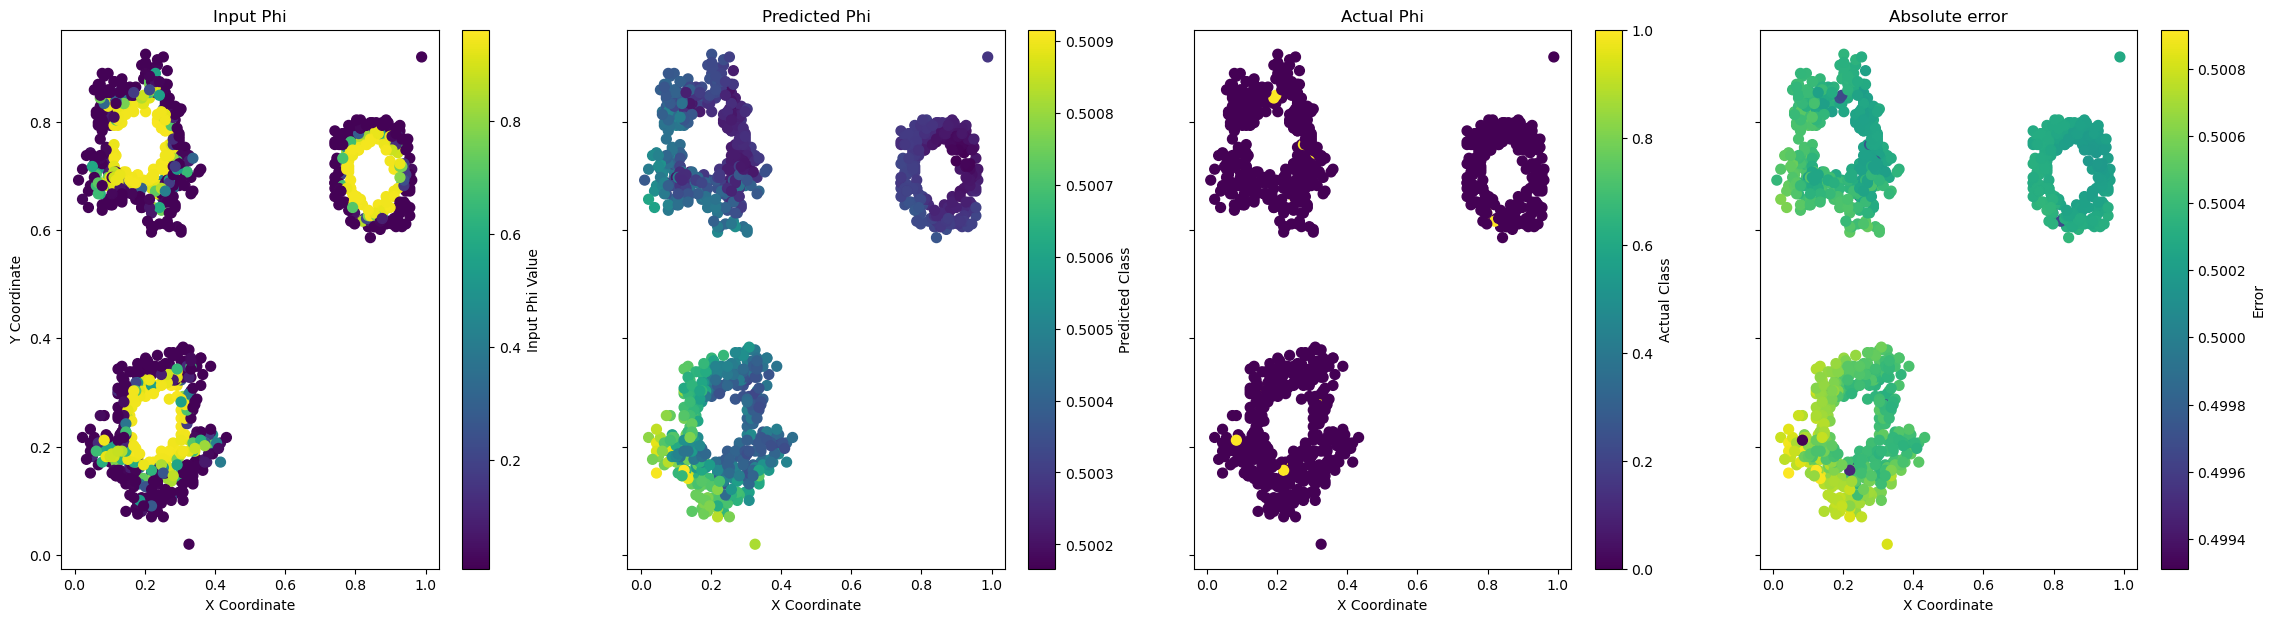

In [33]:
@torch.no_grad()
def evaluate_model(data, model, rotation_angle_degrees=-45, num_samples=100):
    model.eval()
    out = model(data)
    
    # Get all test indices
    test_indices = torch.where(data.test_mask)[0]
    
    # Randomly sample from the test indices if the number is greater than num_samples
    if len(test_indices) > num_samples:
        sampled_indices = test_indices[torch.randperm(len(test_indices))[:num_samples]]
    else:
        sampled_indices = test_indices

    # out_prob = torch.sigmoid(out[sampled_indices].squeeze())  # Apply sigmoid to ensure the outputs are probabilities
    # threshold = 0.7  # Define the threshold
    # pred = (out_prob > threshold).int()  # Convert probabilities to binary labels based on the threshold
    pred = torch.sigmoid(out[sampled_indices].squeeze())
    actual = data.y[sampled_indices]
    input_phi = data.x[sampled_indices, 2]  # Assuming the third column is phi
    error = (pred - actual).abs()  # Calculate error as absolute difference

    # # Calculate accuracy for the sampled cases
    # correct = pred.round().eq(actual.round()).sum().item()
    # total = len(sampled_indices)
    # accuracy = correct / total
    # print(f'Test Accuracy (sampled): {accuracy:.4f} for {num_samples} samples')

    # Reverse the rotation for visualization purposes
    angle = np.radians(rotation_angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle), np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]
    ])

    coords = data.x[sampled_indices][:, :2].cpu().numpy()  # Ensure the first two columns are coordinates
    new_coords = np.dot(coords, rotation_matrix)

    # Visualization of 2D predictions
    fig, ax = plt.subplots(1, 4, figsize=(28, 7), sharex=True, sharey=True)
    scatter = ax[0].scatter(new_coords[:, 0], new_coords[:, 1], c=input_phi.cpu().numpy(), cmap='viridis', s=50)
    ax[0].set_title('Input Phi')
    ax[0].set_xlabel('X Coordinate')
    ax[0].set_ylabel('Y Coordinate')
    plt.colorbar(scatter, ax=ax[0], label='Input Phi Value')

    scatter = ax[1].scatter(new_coords[:, 0], new_coords[:, 1], c=pred.cpu().numpy(), cmap='viridis', s=50)
    ax[1].set_title('Predicted Phi')
    ax[1].set_xlabel('X Coordinate')
    plt.colorbar(scatter, ax=ax[1], label='Predicted Class')

    scatter = ax[2].scatter(new_coords[:, 0], new_coords[:, 1], c=actual.cpu().numpy(), cmap='viridis', s=50)
    ax[2].set_title('Actual Phi')
    ax[2].set_xlabel('X Coordinate')
    plt.colorbar(scatter, ax=ax[2], label='Actual Class')

    # Error visualization
    scatter = ax[3].scatter(new_coords[:, 0], new_coords[:, 1], c=error.cpu().numpy(), cmap='viridis', s=50)
    ax[3].set_title('Absolute error')
    ax[3].set_xlabel('X Coordinate')
    plt.colorbar(scatter, ax=ax[3], label='Error')

    plt.show()

evaluate_model(data, model, 0, num_samples=1000)

In [34]:
# # credits:
# # how to use DDP module with DDP sampler: https://gist.github.com/sgraaf/5b0caa3a320f28c27c12b5efeb35aa4c
# # how to setup a basic DDP example from scratch: https://pytorch.org/tutorials/intermediate/dist_tuto.html
# import os
# import torch
# import torch.distributed as dist
# import torch.multiprocessing as mp
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torchvision import datasets, transforms
# import random

# from torch.nn.parallel import DistributedDataParallel as DDP

# from torch.utils.data import DataLoader, Dataset
# from torch.utils.data.distributed import DistributedSampler
# import math

# def get_dataset():
#     world_size = dist.get_world_size()
#     train_set = datasets.MNIST('./data', train=True, download=True,
#                              transform=transforms.Compose([
#                                  transforms.ToTensor(),
#                                  transforms.Normalize((0.1307,), (0.3081,))
#                              ]))
#     val_set = datasets.MNIST('./data', train=False, download=True,
#                              transform=transforms.Compose([
#                                  transforms.ToTensor(),
#                                  transforms.Normalize((0.1307,), (0.3081,))
#                              ]))
    
#     train_sampler = DistributedSampler(train_set,num_replicas=world_size)
#     val_sampler = DistributedSampler(val_set,num_replicas=world_size)
#     batch_size = int(128 / float(world_size))
#     print(world_size, batch_size)
#     train_loader = DataLoader(
#         dataset=train_set,
#         sampler=train_sampler,
#         batch_size=batch_size
#     )
#     val_loader = DataLoader(
#         dataset=val_set,
#         sampler=val_sampler,
#         batch_size=batch_size
#     )

#     return train_loader, val_loader, batch_size
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)
#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         x = self.softmax(x)
#         return x
# def average_gradients(model):
#     size = float(dist.get_world_size())
#     for param in model.parameters():
#         dist.all_reduce(param.grad.data, op=dist.ReduceOp.SUM)
#         param.grad.data /= size
# def reduce_dict(input_dict, average=True):
#     world_size = float(dist.get_world_size())
#     names, values = [], []
#     for k in sorted(input_dict.keys()):
#         names.append(k)
#         values.append(input_dict[k])
#     values = torch.stack(values, dim=0)
#     dist.all_reduce(values, op=dist.ReduceOp.SUM)
#     if average:
#         values /= world_size
#     reduced_dict = {k: v for k, v in zip(names, values)}
#     return reduced_dict
# def train(model,train_loader,optimizer,batch_size):
#     device = torch.device(f"cuda:{dist.get_rank()}")
#     train_num_batches = int(math.ceil(len(train_loader.dataset) / float(batch_size)))
#     model.train()
#     # let all processes sync up before starting with a new epoch of training
#     # dist.barrier()
#     criterion = nn.CrossEntropyLoss().to(device)
#     train_loss = 0.0
#     for data, target in train_loader:
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target)
#         loss.backward()
#         # average gradient as DDP doesn't do it correctly
#         average_gradients(model)
#         optimizer.step()
#         loss_ = {'loss': torch.tensor(loss.item()).to(device)}
#         train_loss += reduce_dict(loss_)['loss'].item()
#         # cleanup
#         # dist.barrier()
#         # data, target, output = data.cpu(), target.cpu(), output.cpu()
#     train_loss_val = train_loss / train_num_batches
#     return train_loss_val
# def accuracy(output, target, topk=(1,)):
#     """Computes the accuracy over the k top predictions for the specified values of k"""
#     with torch.no_grad():
#         maxk = max(topk)
#         batch_size = target.size(0)

#         _, pred = output.topk(maxk, 1, True, True)
#         pred = pred.t()
#         correct = pred.eq(target.view(1, -1).expand_as(pred))

#         res = []
#         for k in topk:
#             correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
#             res.append(correct_k.div_(batch_size))
#         return res
# def val(model, val_loader,batch_size):
#     device = torch.device(f"cuda:{dist.get_rank()}")
#     val_num_batches = int(math.ceil(len(val_loader.dataset) / float(batch_size)))
#     model.eval()
#     # let all processes sync up before starting with a new epoch of training
#     # dist.barrier()
#     criterion = nn.CrossEntropyLoss().to(device)
#     val_loss = 0.0
#     with torch.no_grad():
#         for data, target in val_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             loss = criterion(output, target)
#             loss_ = {'loss': torch.tensor(loss.item()).to(device)}
#             val_loss += reduce_dict(loss_)['loss'].item()
#     val_loss_val = val_loss / val_num_batches
#     return val_loss_val
# def run(rank, world_size):
#     torch.cuda.set_device(rank)
#     torch.cuda.empty_cache()
#     device = torch.device(f"cuda:{rank}")
#     torch.manual_seed(1234)
#     train_loader, val_loader, batch_size = get_dataset()
#     model = Net().to(device)
#     model = nn.SyncBatchNorm.convert_sync_batchnorm(model) # use if model contains batchnorm.
#     model = DDP(model,device_ids=[rank],output_device=rank)
#     optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.5)
#     history =  {
#             "rank": rank,
#             "train_loss_val": [],
#             "train_acc_val": [],
#             "val_loss_val": [],
#             "val_acc_val": []
#         }
#     if rank == 0:
#         history = {
#             "rank": rank,
#             "train_loss_val": [],
#             "train_acc_val": [],
#             "val_loss_val": [],
#             "val_acc_val": []
#         }
#     for epoch in range(10):
#         train_loss_val = train(model,train_loader,optimizer,batch_size)
#         val_loss_val = val(model,val_loader,batch_size)
#         if rank == 0:
#             print(f'Rank {rank} epoch {epoch}: {train_loss_val:.2f}/{val_loss_val:.2f}')
#             history['train_loss_val'].append(train_loss_val)
#             history['val_loss_val'].append(val_loss_val)
#     print(f'Rank {rank} finished training')
#     print(history)
#     cleanup(rank)  

# def cleanup(rank):
#     # dist.cleanup()  
#     dist.destroy_process_group()
#     print(f"Rank {rank} is done.")
# def setup_for_distributed(is_master):
#     """
#     This function disables printing when not in master process
#     """
#     import builtins as __builtin__
#     builtin_print = __builtin__.print

#     def print(*args, **kwargs):
#         force = kwargs.pop('force', False)
#         if is_master or force:
#             builtin_print(*args, **kwargs)

#     __builtin__.print = print
# def init_process(
#         rank, # rank of the process
#         world_size, # number of workers
#         fn, # function to be run
#         # backend='gloo',# good for single node
#         # backend='nccl' # the best for CUDA
#         backend='gloo'
#     ):
#     # information used for rank 0
#     os.environ['MASTER_ADDR'] = '127.0.0.1'
#     os.environ['MASTER_PORT'] = '29500'
#     dist.init_process_group(backend, rank=rank, world_size=world_size)
#     dist.barrier()
#     setup_for_distributed(rank == 0)
#     fn(rank, world_size)


# if __name__ == "__main__":
#     world_size = 2
#     processes = []
#     mp.set_start_method("spawn")
#     for rank in range(world_size):
#         p = mp.Process(target=init_process, args=(rank, world_size, run))
#         p.start()
#         processes.append(p)

#     for p in processes:
#         p.join()